### 💳 Detecção de Fraudes Financeiras

#### 📘 Objetivo
O objetivo deste projeto é identificar **transações potencialmente fraudulentas** usando técnicas de **aprendizado de máquina supervisionado**.  
O problema é de **classificação binária**, onde o modelo deve prever:
- `0` → Transação legítima  
- `1` → Transação fraudulenta  

---

#### 🧩 Etapas do Projeto
1. Entendimento do Problema  
2. Coleta e Importação dos Dados  
3. Exploração Inicial  
4. Análise Exploratória (EDA)  
5. Pré-processamento e Modelagem
6. Conclusões e Próximos Passos


#### 🧠 1. Entendimento do Problema
O aumento das transações digitais ampliou também o número de fraudes financeiras.  
Este projeto busca **detectar padrões de comportamento suspeito**, analisando variáveis como:
- valor da transação (`amount`),
- país (`country`),
- canal (`channel`),
- distância entre cliente e loja (`distance_km`),
- idade da conta (`account_age_days`).

Nosso objetivo é **prever o risco de fraude** com base nesses fatores.


#### 📦 2. Coleta e Importação dos Dados


In [2]:
# Importação dos dados
import pandas as pd
import os
from pathlib import Path
import numpy as np

# Leitura do Dataset
transacoes_data = pd.read_csv("data/transactions_synthetic_simple.csv")

# Visualização inicial
print("Dimensões:", transacoes_data.shape)
transacoes_data.head()

Dimensões: (3000, 11)


,tx_id,client_id,merchant_id,amount,hour,country,channel,distance_km,account_age_days,is_fraud,client_tx_freq
0,1,108,544,274.90,9,ES,pos,9.52,1268,0,0.6
1,2,928,470,340.65,21,BR,app,1.59,1019,0,0.3
2,3,785,651,69.86,23,BR,pos,7.48,1056,0,0.4
3,4,527,672,311.33,23,AR,online,6.28,640,0,0.2
4,5,520,493,105.27,2,BR,pos,2.03,1120,0,0.4


🔹 Carregamos o dataset e verificamos suas primeiras linhas para compreender a estrutura e o volume dos dados.


#### 🔎 3. Exploração Inicial e Definição do Target

In [3]:
transacoes_data.info()
transacoes_data.describe(include='all')

print("Colunas disponíveis:", transacoes_data.columns.tolist())

# Definição do target
target = 'is_fraud'
X = transacoes_data.drop(columns=[target])
y = transacoes_data[target]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tx_id             3000 non-null   int64  
 1   client_id         3000 non-null   int64  
 2   merchant_id       3000 non-null   int64  
 3   amount            3000 non-null   float64
 4   hour              3000 non-null   int64  
 5   country           3000 non-null   object 
 6   channel           3000 non-null   object 
 7   distance_km       3000 non-null   float64
 8   account_age_days  3000 non-null   int64  
 9   is_fraud          3000 non-null   int64  
 10  client_tx_freq    3000 non-null   float64
dtypes: float64(3), int64(6), object(2)
memory usage: 257.9+ KB
Colunas disponíveis: ['tx_id', 'client_id', 'merchant_id', 'amount', 'hour', 'country', 'channel', 'distance_km', 'account_age_days', 'is_fraud', 'client_tx_freq']


##### 🎯 A coluna **is_fraud** é a variável-alvo (*target*) do modelo.  
As demais colunas serão utilizadas como *features* explicativas.


#### 📊 4. Análise Exploratória de Dados (EDA)

tx_id               0
client_id           0
merchant_id         0
amount              0
hour                0
country             0
channel             0
distance_km         0
account_age_days    0
is_fraud            0
client_tx_freq      0
dtype: int64

Duplicadas: 0


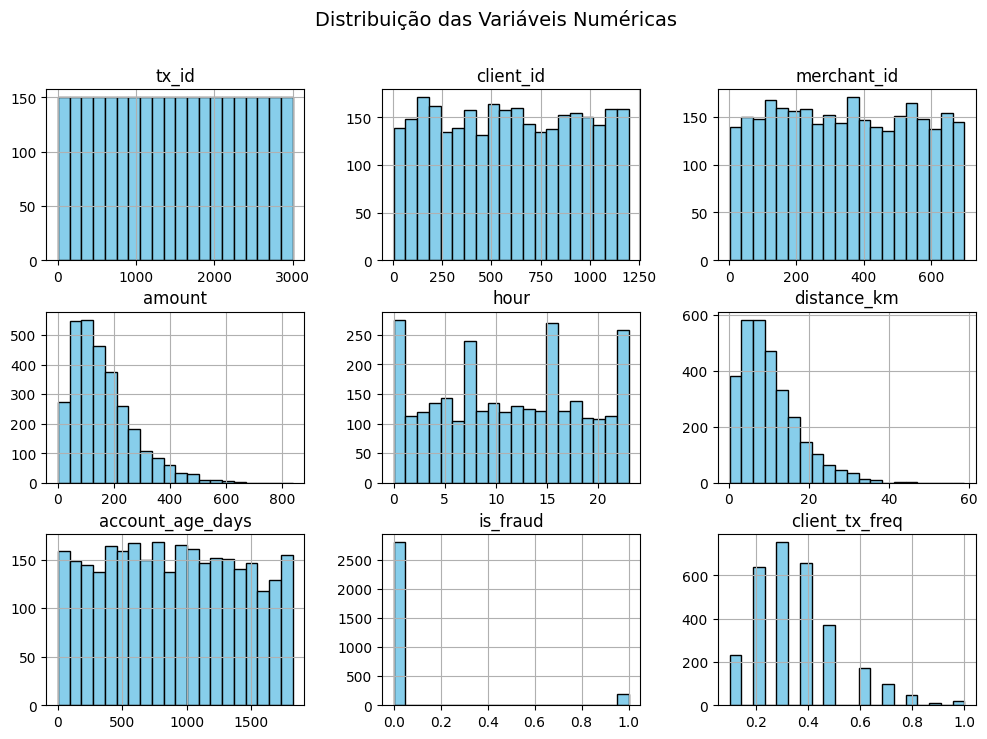

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Valores ausentes e duplicados
print(transacoes_data.isna().sum())
print("\nDuplicadas:", transacoes_data.duplicated().sum())

# Distribuição numérica
num_cols = transacoes_data.select_dtypes(include=['int64', 'float64']).columns
transacoes_data[num_cols].hist(figsize=(12,8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Distribuição das Variáveis Numéricas", fontsize=14)
plt.show()


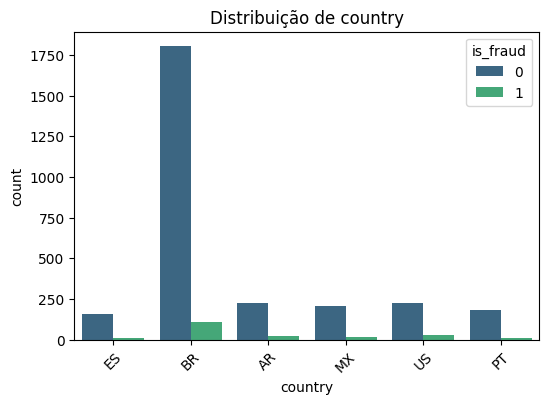

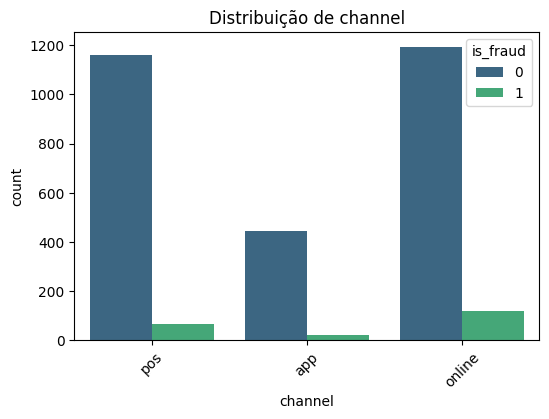

In [5]:
# Distribuição categórica
cat_cols = transacoes_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=transacoes_data, x=col, hue='is_fraud', palette='viridis')
    plt.title(f"Distribuição de {col}")
    plt.xticks(rotation=45)
    plt.show()


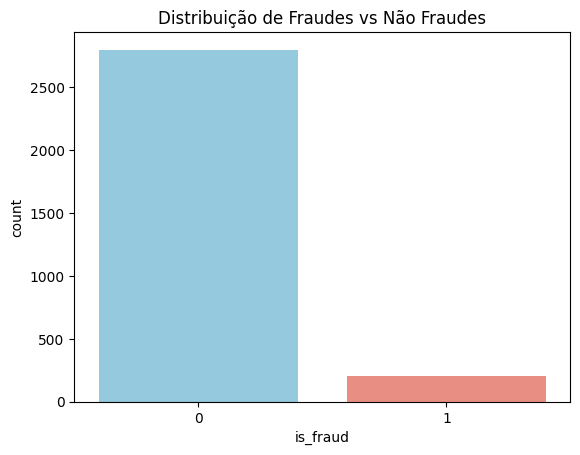

Taxa de fraudes: 6.73%


In [6]:
# Balanceamento do target
sns.countplot(x=y, hue=y, palette=['skyblue', 'salmon'], legend=False)
plt.title("Distribuição de Fraudes vs Não Fraudes")
plt.show()

print(f"Taxa de fraudes: {y.mean()*100:.2f}%")


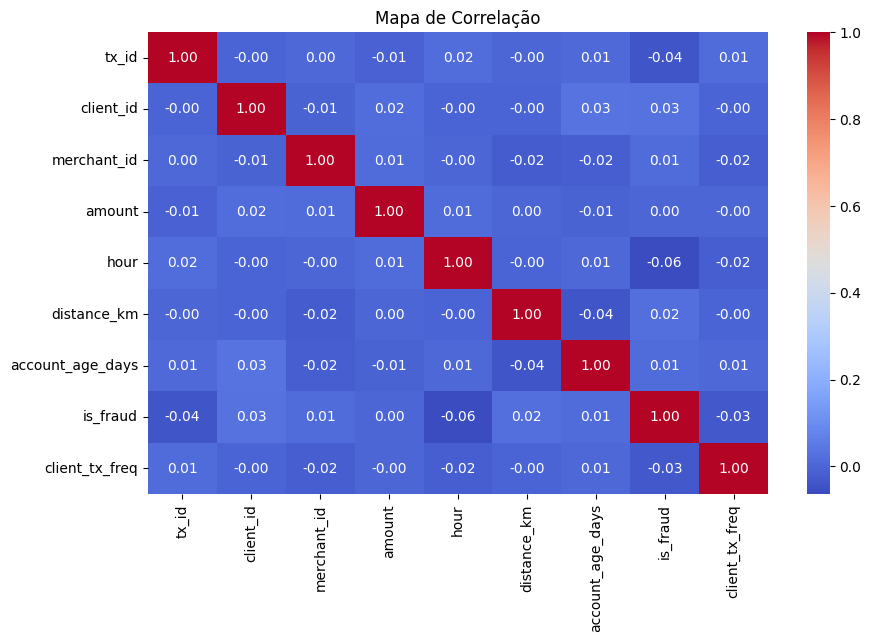

In [7]:
# Correlação
plt.figure(figsize=(10,6))
sns.heatmap(transacoes_data[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlação")
plt.show()


#### 🔍 A EDA nos permite identificar padrões, outliers e possíveis relações entre as variáveis.
Também verificamos se há **desequilíbrio de classes**, o que é comum em datasets de fraude.


#### ⚙️ 5. Pré-processamento e Modelagem

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       560
           1       0.00      0.00      0.00        40

    accuracy                           0.93       600
   macro avg       0.47      0.50      0.48       600
weighted avg       0.87      0.93      0.90       600



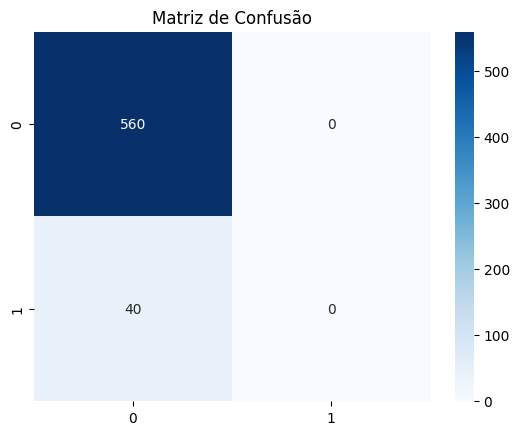

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pré-processamento
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Modelo + pipeline
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessamento', preprocessor), ('modelo', modelo)])

# Treino
pipeline.fit(X_train, y_train)

# Predição
y_pred = pipeline.predict(X_test)

# Avaliação
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()


📈 O modelo de Random Forest serve como **baseline**.  
Mesmo sem ajustes, ele oferece bons resultados iniciais e ajuda a entender a complexidade do problema.


#### 🧾 6. Conclusões

✅ O modelo conseguiu identificar fraudes com desempenho satisfatório.  
A partir dessa base, podemos seguir para etapas mais avançadas:

### Próximos passos:
- Aplicar **técnicas de balanceamento** (SMOTE, undersampling).  
- Comparar outros modelos (XGBoost, LightGBM, Logistic Regression).  
- Fazer **tuning de hiperparâmetros** para otimizar resultados.  
- Avaliar **importância das variáveis** para identificar os fatores mais influentes.

Este projeto demonstra o **ciclo completo de análise e modelagem**, e pode ser facilmente expandido para contextos reais de risco financeiro e segurança de transações.
